In [ ]:
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.sts.models.stochastictrend import StochasticTrend
from utils.sts.simul import stochastic_trend, plot_stochastic_trend

# from tqdm.notebook import tqdm 
# import tqdm as notebook_tqdm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [8, 5] # 12, 7
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
RANDOM_SEED = 11111
rng = np.random.default_rng(RANDOM_SEED)

C:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\PYTHON\utils\sts\tools.py:70: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


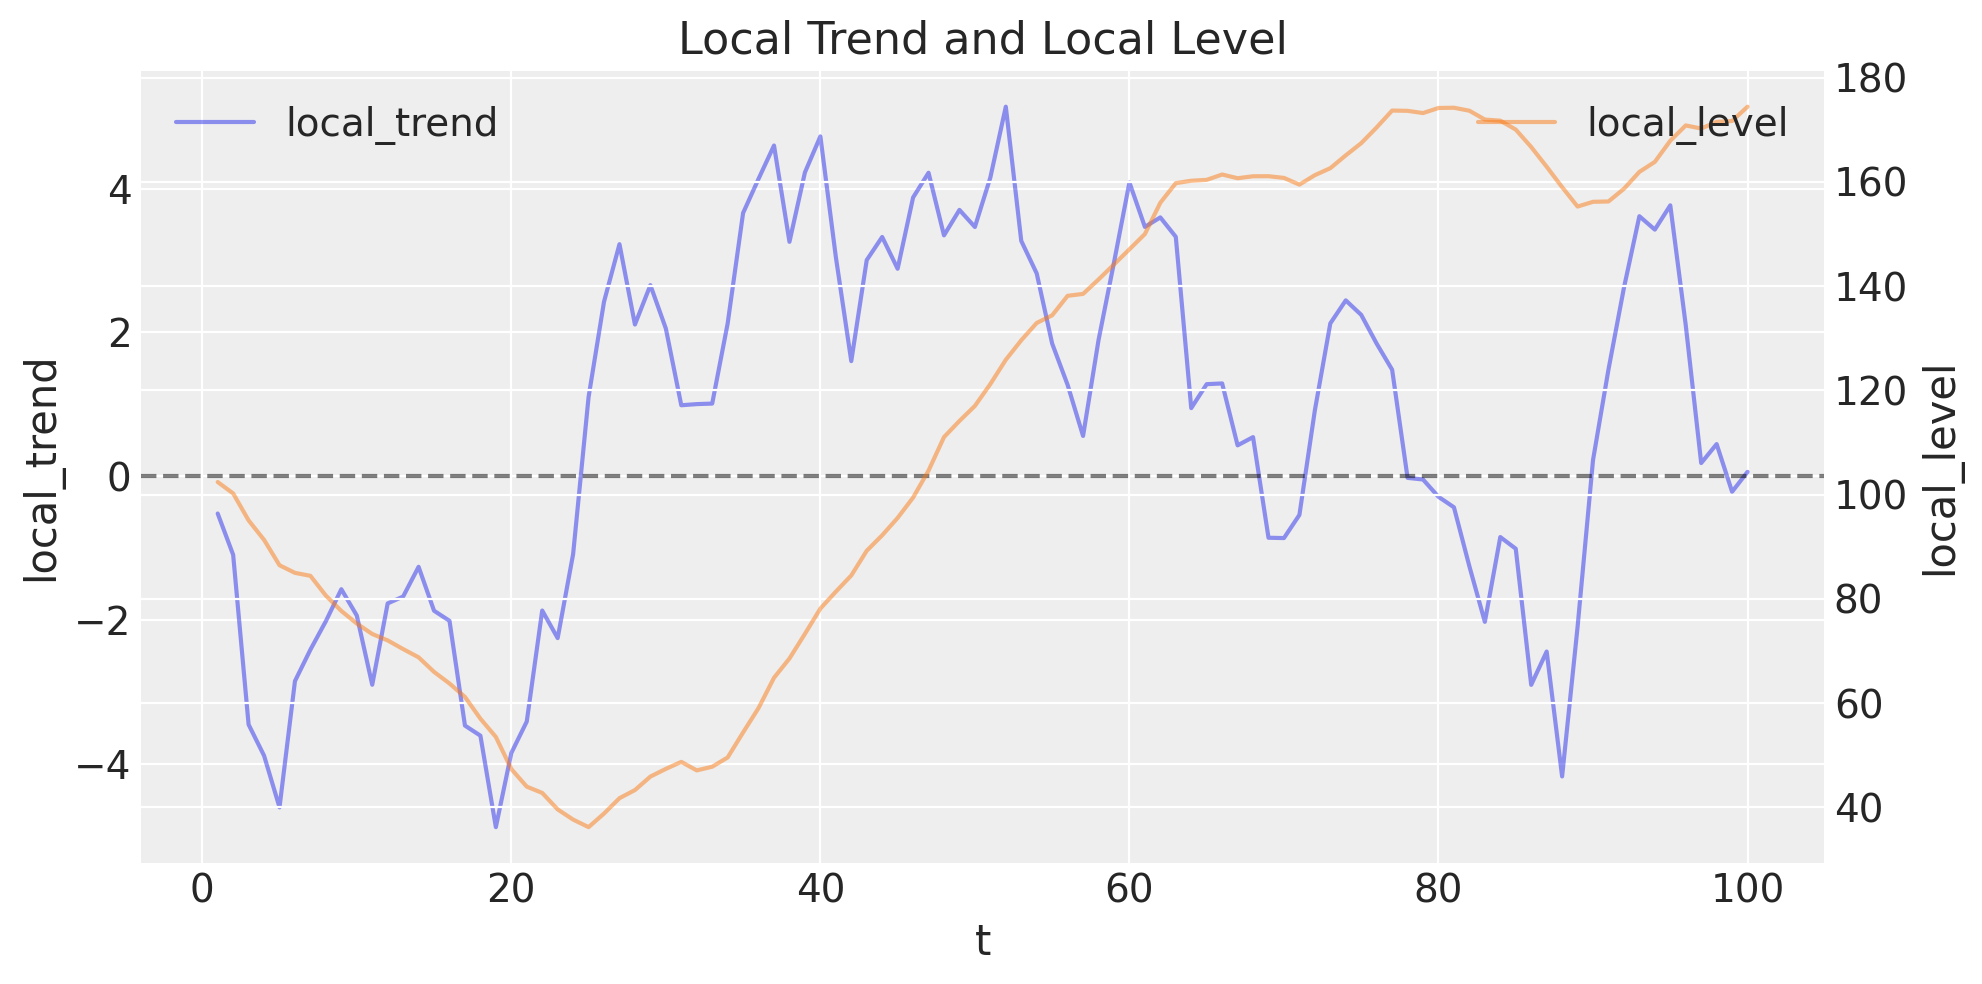

In [3]:
df_stoch_trend = stochastic_trend(
    rng, 
    N = 100, 
    sigma_local_trend = 1, 
    local_trend_0 = 1, 
    sigma_local_level = 1, 
    local_level_0 = 100
    )

plot_stochastic_trend(df_stoch_trend)

In [4]:
df = df_stoch_trend.assign(y = lambda x: x.local_level + rng.normal(0, 1, 100))

t = df["t"].to_numpy()

# Max-min scaling
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

X = pd.DataFrame({"t": t})

y = df["y"].to_numpy()
y_max = np.max(y)
y = y / y_max

In [5]:
model_config = {
            "sigma_local_trend_lam_prior": y_max,
            "sigma_local_level_lam_prior": y_max,
            "sigma_lam_prior": y_max,
        }

sampler_config = {
    'return_inferencedata': True, 
    # 'target_accept': 0.9,
    # 'draws': 12000,
    'chains': 3,
    'nuts_sampler': "numpyro",
    # 'random_seed': rng, # ESTO DA ERROR PORQUE NO ES SERIALIZABLE
    'idata_kwargs': {"log_likelihood": True},
    }

In [6]:
model = StochasticTrend(model_config, sampler_config)

In [7]:
idata = model.fit(X, y)

Sampling: [diff_local_level, diff_local_trend, local_level_0, local_trend_0, sigma, sigma_local_level, sigma_local_trend, y]
Compiling...
Compilation time = 0:00:02.838810
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:21.740695
Transforming variables...
Transformation time = 0:00:00.933190
Computing Log Likelihood...
Log Likelihood time = 0:00:00.689810
Sampling: [diff_local_level, diff_local_trend, local_level_0, local_trend_0, sigma, sigma_local_level, sigma_local_trend, y]
Sampling: [y]


In [9]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

In [14]:
prior_pc = model.sample_prior_predictive(X)

Sampling: [diff_local_level, diff_local_trend, local_level_0, local_trend_0, sigma, sigma_local_level, sigma_local_trend, y]


In [15]:
fname = "stochastic_trend_model_v1.nc"
model.save(fname)

In [16]:
model_2 = StochasticTrend.load(fname)

c:\Users\mcondedesimon\OneDrive - Deloitte (O365D)\Documents\PLAYGROUND\tst_pymc\.venv\Lib\site-packages\arviz\data\inference_data.py:153: UserWarning: fit_data group is not defined in the InferenceData scheme
  warnings.warn(


In [17]:
# point estimates (the mean) 
pred_mean = model_2.predict(X)

Sampling: [y]


In [19]:
# full posterior prediction (samples)
posterior_pc = model_2.predict_posterior(X)

Sampling: [y]


In [22]:
posterior_pc

<xarray.DataArray 'y' (n_obs: 100, sample: 3000)>
array([[0.59119992, 0.58229516, 0.5723007 , ..., 0.57934803, 0.58380935,
        0.57387102],
       [0.55396223, 0.55660707, 0.56160996, ..., 0.55560271, 0.57748441,
        0.56179002],
       [0.54138207, 0.53369054, 0.53373358, ..., 0.53928665, 0.53623352,
        0.53274948],
       ...,
       [0.97058247, 0.97970714, 0.97189404, ..., 0.97402992, 0.97365796,
        0.97101195],
       [0.97849892, 0.98673495, 0.9729386 , ..., 0.9768144 , 0.97978126,
        0.97022402],
       [0.9956116 , 0.99841412, 1.00712408, ..., 0.98986012, 0.99725814,
        0.98717433]])
Coordinates:
  * n_obs    (n_obs) int32 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * sample   (sample) object MultiIndex
  * chain    (sample) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2 2 2 2
  * draw     (sample) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

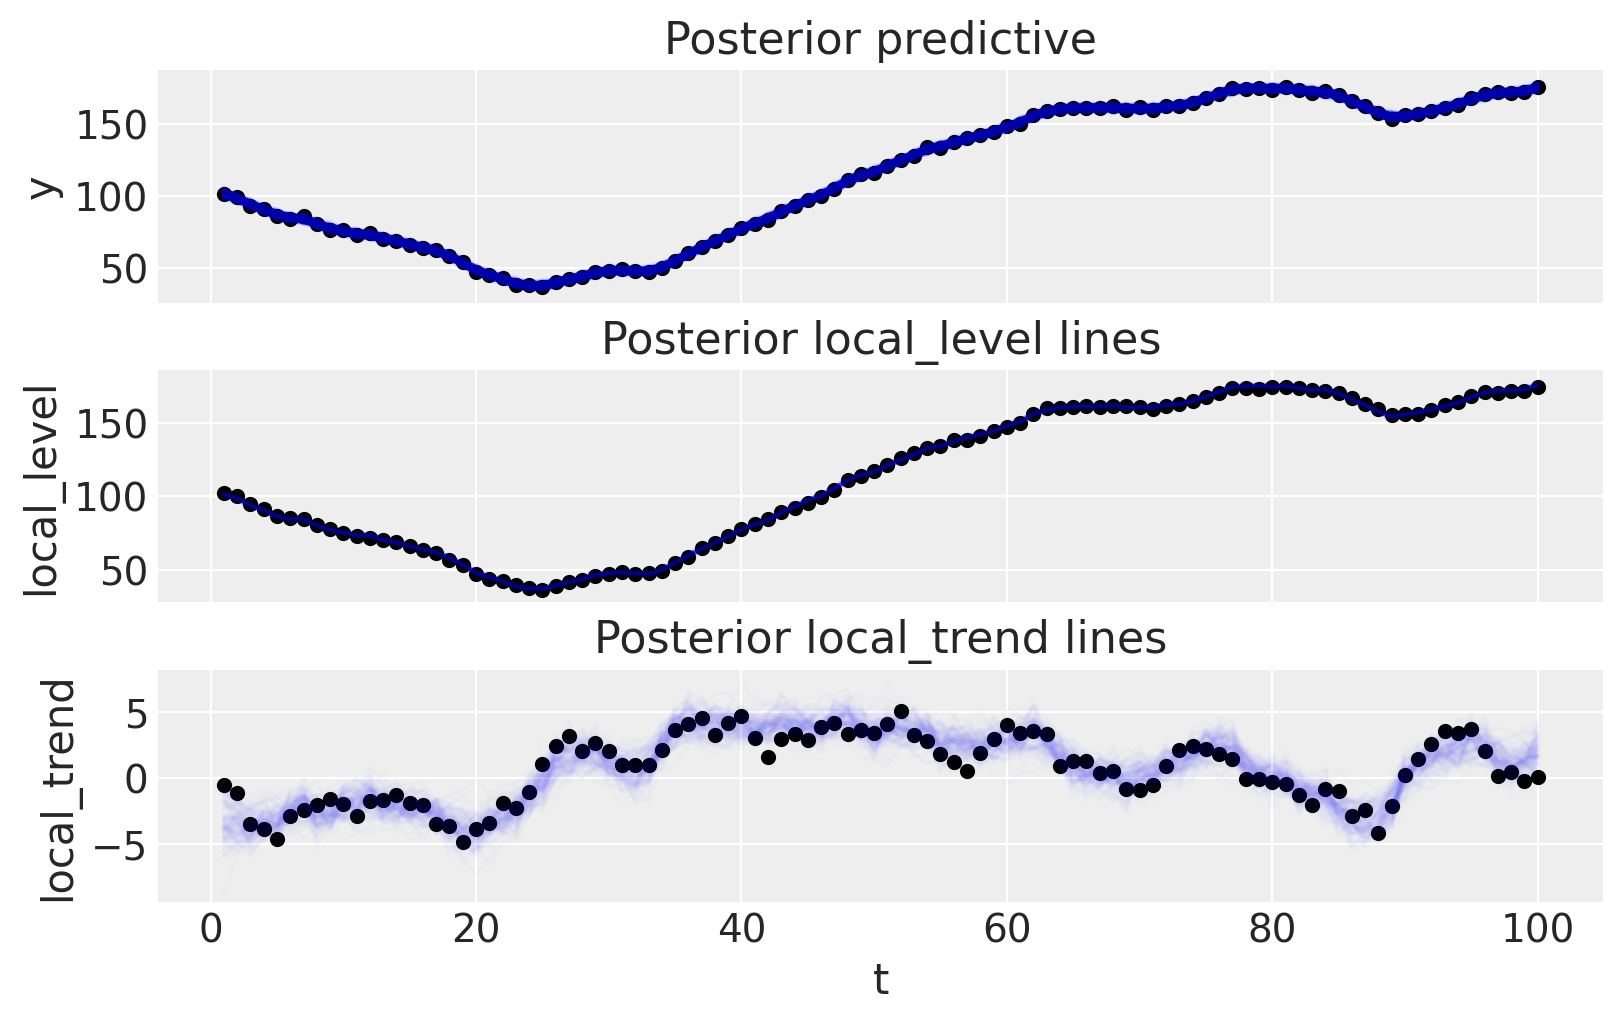

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)

ax[0].plot(
    df["t"],
    posterior_pc * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="y", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")

ax[1].plot(
    df["t"],
    az.extract(idata, group="posterior", num_samples=100)["local_level"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_level", color="k", ax=ax[1])
ax[1].set_title("Posterior local_level lines");

ax[2].plot(
    df["t"],
    az.extract(idata, group="posterior", num_samples=100)["local_trend"] * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="t", y="local_trend", color="k", ax=ax[2])
ax[2].set_title("Posterior local_trend lines");